# MNIST with LeNet-5

This file is extracted from mnist_dlsys.py, with extra code about logging and plotting added.

## Imports

In [1]:
import sys
sys.path.append('../../')

import numpy as np
import argparse
import six.moves.cPickle as pickle
import gzip
import os
import time
from tqdm import tqdm

import tvm
from system_level import autodiff as ad
from system_level import tvm_op

import warnings
warnings.filterwarnings("ignore")

## Setup

In [2]:
tgt = "llvm"
tgt_host = "llvm"

# create context object
executor_ctx = tvm.device(tgt, 0)

print_loss_val_each_epoch = True
num_epochs = 5

def convert_to_one_hot(vals):
    """Helper method to convert label array to one-hot array."""
    one_hot_vals = np.zeros((vals.size, 10))
    one_hot_vals[np.arange(vals.size), vals] = 1
    return one_hot_vals


## Load and examine dataset

In [3]:
""" Load the dataset
Code adapted from http://deeplearning.net/tutorial/code/logistic_sgd.py

:type dataset: string
:param dataset: the path to the dataset (here MNIST)
"""
# Download the MNIST dataset if it is not present
dataset = "mnist.pkl.gz"

data_dir, data_file = os.path.split(dataset)
if data_dir == "" and not os.path.isfile(dataset):
    # Check if dataset is in the data directory.
    new_path = os.path.join(
        os.path.split(__file__)[0],
        dataset
    )
    if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
        dataset = new_path

if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
    from six.moves import urllib
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

print('Loading data...')

# Load the dataset
with gzip.open(dataset, 'rb') as f:
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    except:
        train_set, valid_set, test_set = pickle.load(f)
# train_set, valid_set, test_set format: tuple(input, target)
# input is a numpy.ndarray of 2 dimensions (a matrix), np.float32
# where each row corresponds to an example. target is a
# numpy.ndarray of 1 dimension (vector), np.int64 that has the same length
# as the number of rows in the input. It should give the target
# to the example with the same index in the input.
print('Loaded train_set, valid_set and test_set.')

Loading data...
Loaded train_set, valid_set and test_set.


In [4]:
print(train_set[0].shape)
print(train_set[1].shape)

# because we use lenet, we need to reshape the data
train_set = (train_set[0].reshape((-1, 1, 28, 28)), train_set[1])
valid_set = (valid_set[0].reshape((-1, 1, 28, 28)), valid_set[1])
test_set = (test_set[0].reshape((-1, 1, 28, 28)), test_set[1])

print(train_set[0].shape)
print(train_set[1].shape)

(50000, 784)
(50000,)
(50000, 1, 28, 28)
(50000,)


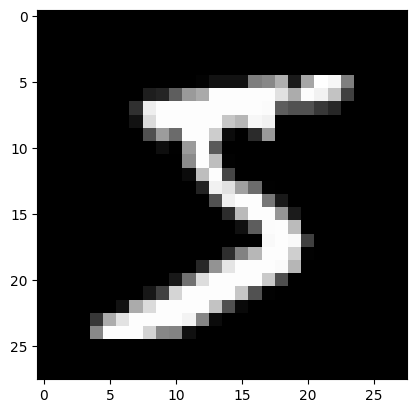

In [5]:
# plot a random sample
import matplotlib.pyplot as plt
plt.imshow(train_set[0][0][0], cmap='gray')
plt.show()

## Construct the computational graph

![](../images/lenet.png)

In [6]:
print("=== Declaring Weights ===")

F1 = ad.Variable(name="F1") # conv2d kernel
BN1_gamma = ad.Variable(name="BN1_gamma") # batch norm
BN1_beta = ad.Variable(name="BN1_beta") # batch norm

F2 = ad.Variable(name="F2") # conv2d kernel
BN2_gamma = ad.Variable(name="BN2_gamma") # batch norm
BN2_beta = ad.Variable(name="BN2_beta") # batch norm

W1 = ad.Variable(name="W1") # fully connected weight
b1 = ad.Variable(name="b1") # fully connected bias

W2 = ad.Variable(name="W2") # fully connected weight
b2 = ad.Variable(name="b2") # fully connected bias

W3 = ad.Variable(name="W3") # fully connected weight
b3 = ad.Variable(name="b3") # fully connected bias

X = ad.Variable(name="X") # input
y_ = ad.Variable(name="y_") # label

=== Declaring Weights ===


In [7]:
print("=== Constructing Computational Graph ===")

# CNN1: bn(maxpool(relu(conv(X F))))
z1 = ad.conv2d_op(X, F1)
z2 = ad.relu_op(z1)
z3 = ad.maxpool2d_op(z2, pool_size=2, stride=2)
z4 = ad.batchnorm2d_op(z3, BN1_gamma, BN1_beta)

# CNN2: bn(maxpool(relu(conv(z3, F2))))
z5 = ad.conv2d_op(z4, F2)
z6 = ad.relu_op(z5)
z7 = ad.maxpool2d_op(z6, pool_size=2, stride=2)
z8 = ad.batchnorm2d_op(z7, BN2_gamma, BN2_beta)

# flatten
CHW = (16, 4, 4)
z9 = ad.flatten_op(z8, CHW)

# mlp: relu(matmul(z7, W1) + b1)
z10 = ad.matmul_op(z9, W1)
z11 = ad.relu_op(z10 + ad.broadcastto_op(b1, z10))
z12 = ad.matmul_op(z11, W2) 
z13 = ad.relu_op(z12 + ad.broadcastto_op(b2, z12))
z14 = ad.matmul_op(z13, W3)
y = z14 + ad.broadcastto_op(b3, z14)

# softmax & cross entropy
loss = ad.softmaxcrossentropy_op(y, y_)

grad_F1, grad_BN1_gamma, grad_BN1_beta, grad_F2, grad_BN2_gamma, grad_BN2_beta, grad_W1, grad_W2, grad_W3, grad_b1, grad_b2, grad_b3 = ad.gradients(
    loss, [F1, BN1_gamma, BN1_beta, F2, BN2_gamma, BN2_beta, W1, W2, W3, b1, b2, b3])
     
executor = ad.Executor(
    [loss, grad_F1, grad_BN1_gamma, grad_BN1_beta, grad_F2, grad_BN2_gamma, grad_BN2_beta, grad_W1, grad_W2, grad_W3, grad_b1, grad_b2, grad_b3, y],
    ctx=executor_ctx)

=== Constructing Computational Graph ===


In [8]:
print("=== Initializing Weights ===")

# Read input data
train_set_x, train_set_y = train_set
valid_set_x, valid_set_y = valid_set
test_set_x, test_set_y = test_set
# Set up minibatch
batch_size = 1000
n_train_batches = train_set_x.shape[0] // batch_size
n_valid_batches = valid_set_x.shape[0] // batch_size

print("Start training loop...")

# Initialize parameters
rand = np.random.RandomState(seed=42)
# n*1*28*28
F1_val = rand.normal(scale=0.1, size=(6, 1, 5, 5)).astype(np.float32)
# n*6*24*24
# maxpool
# n*6*12*12
BN1_gamma_val = np.ones(shape=(1, 6, 1, 1)).astype(np.float32)
BN1_beta_val = np.zeros(shape=(1, 6, 1, 1)).astype(np.float32)

F2_val = rand.normal(scale=0.1, size=(16, 6, 5, 5)).astype(np.float32)
# n*16*8*8
# maxpool
# n*16*4*4
BN2_gamma_val = np.ones(shape=(1, 16, 1, 1)).astype(np.float32)
BN2_beta_val = np.zeros(shape=(1, 16, 1, 1)).astype(np.float32)

W1_val = rand.normal(scale=0.1, size=(16*4*4, 120)).astype(np.float32)
b1_val = rand.normal(scale=0.1, size=(120)).astype(np.float32)

W2_val = rand.normal(scale=0.1, size=(120, 84)).astype(np.float32)
b2_val = rand.normal(scale=0.1, size=(84)).astype(np.float32)

W3_val = rand.normal(scale=0.1, size=(84, 10)).astype(np.float32)
b3_val = rand.normal(scale=0.1, size=(10)).astype(np.float32)

X_val = np.empty(shape=(batch_size, 1, 28, 28), dtype=np.float32)
y_val = np.empty(shape=(batch_size, 10), dtype=np.float32)

valid_X_val = np.empty(shape=(batch_size, 1, 28, 28), dtype=np.float32)
valid_y_val = np.empty(shape=(batch_size, 10), dtype=np.float32)

test_X_val = np.empty(shape=(1, 1, 28, 28), dtype=np.float32)
test_y_val = np.empty(shape=(1, 10), dtype=np.float32)

# wrap with tvm.nd.array
F1_val = tvm.nd.array(F1_val)
BN1_gamma_val = tvm.nd.array(BN1_gamma_val)
BN1_beta_val = tvm.nd.array(BN1_beta_val)
F2_val = tvm.nd.array(F2_val)
BN2_gamma_val = tvm.nd.array(BN2_gamma_val)
BN2_beta_val = tvm.nd.array(BN2_beta_val)
W1_val = tvm.nd.array(W1_val)
b1_val = tvm.nd.array(b1_val)
W2_val = tvm.nd.array(W2_val)
b2_val = tvm.nd.array(b2_val)
W3_val = tvm.nd.array(W3_val)
b3_val = tvm.nd.array(b3_val)

X_val = tvm.nd.array(X_val)
y_val = tvm.nd.array(y_val)
valid_X_val = tvm.nd.array(valid_X_val)
valid_y_val = tvm.nd.array(valid_y_val)
test_X_val = tvm.nd.array(test_X_val)
test_y_val = tvm.nd.array(test_y_val)

=== Initializing Weights ===
Start training loop...


## Train & Eval

In [9]:
# training loop
lr = 1.0e-3
# JIT compile sgd update ops
F1_sgd_update_func = tvm_op.make_sgd_update(
    F1_val.shape, lr, tgt, tgt_host, "F1_sgd_update")
BN1_gamma_sgd_update_func = tvm_op.make_sgd_update(
    BN1_gamma_val.shape, lr, tgt, tgt_host, "BN1_gamma_sgd_update")
BN1_beta_sgd_update_func = tvm_op.make_sgd_update(
    BN1_beta_val.shape, lr, tgt, tgt_host, "BN1_beta_sgd_update")

F2_sgd_update_func = tvm_op.make_sgd_update(
    F2_val.shape, lr, tgt, tgt_host, "F2_sgd_update")
BN2_gamma_sgd_update_func = tvm_op.make_sgd_update(
    BN2_gamma_val.shape, lr, tgt, tgt_host, "BN2_gamma_sgd_update")
BN2_beta_sgd_update_func = tvm_op.make_sgd_update(
    BN2_beta_val.shape, lr, tgt, tgt_host, "BN2_beta_sgd_update")

W1_sgd_update_func = tvm_op.make_sgd_update(
    W1_val.shape, lr, tgt, tgt_host, "W1_sgd_update")
W2_sgd_update_func = tvm_op.make_sgd_update(
    W2_val.shape, lr, tgt, tgt_host, "W2_sgd_update")
W3_sgd_update_func = tvm_op.make_sgd_update(
    W3_val.shape, lr, tgt, tgt_host, "W3_sgd_update")
b1_sgd_update_func = tvm_op.make_sgd_update(
    b1_val.shape, lr, tgt, tgt_host, "b1_sgd_update")
b2_sgd_update_func = tvm_op.make_sgd_update(
    b2_val.shape, lr, tgt, tgt_host, "b2_sgd_update")
b3_sgd_update_func = tvm_op.make_sgd_update(
    b3_val.shape, lr, tgt, tgt_host, "b3_sgd_update")

In [10]:
time_measurements = []
train_acc_values = []
val_acc_values = []

for i in range(num_epochs):
    print(f"***** EPOCH {i+1} *****")
    
    # eval on train set
    train_correct = 0
    train_total = 0
    for minibatch_index in tqdm(range(n_train_batches)):
        minibatch_start = minibatch_index * batch_size
        minibatch_end = (minibatch_index + 1) * batch_size
        X_val.copyfrom(train_set_x[minibatch_start:minibatch_end])
        y_val.copyfrom(
            convert_to_one_hot(train_set_y[minibatch_start:minibatch_end]))
        _, _, _, _, _, _, _, _, _, _, _, _, y_pred = executor.run(
            feed_dict={X: X_val, y_: y_val, F1: F1_val, F2: F2_val, W1: W1_val, W2: W2_val, W3: W3_val, b1: b1_val, b2: b2_val, b3: b3_val})
        train_correct += np.sum(y_pred.asnumpy().argmax(axis=1) == train_set_y[minibatch_start:minibatch_end])
        train_total += minibatch_end - minibatch_start
    train_acc = train_correct / train_total
    train_acc_values.append(train_acc)
    print("accuracy on training set: ", train_acc)
    
    # eval on valid set
    val_correct = 0
    val_total = 0
    for minibatch_index in range(n_valid_batches):
        print("valid minibatch: ", minibatch_index, "/", n_valid_batches)
        minibatch_start = minibatch_index * batch_size
        minibatch_end = (minibatch_index + 1) * batch_size
        X_val.copyfrom(valid_set_x[minibatch_start:minibatch_end])
        y_val.copyfrom(
            convert_to_one_hot(valid_set_y[minibatch_start:minibatch_end]))
        _, _, _, _, _, _, _, _, _, _, _, _, _, y_pred = executor.run(
            feed_dict={
                X: X_val, 
                y_: y_val, 
                F1: F1_val, 
                BN1_gamma: BN1_gamma_val, 
                BN1_beta: BN1_beta_val, 
                F2: F2_val, 
                BN2_gamma: BN2_gamma_val, 
                BN2_beta: BN2_beta_val, 
                W1: W1_val, 
                W2: W2_val, 
                W3: W3_val, 
                b1: b1_val, 
                b2: b2_val, 
                b3: b3_val})
        val_correct += np.sum(y_pred.asnumpy().argmax(axis=1) == valid_set_y[minibatch_start:minibatch_end])
        val_total += minibatch_end - minibatch_start
    val_acc = val_correct / val_total
    val_acc_values.append(val_acc)
    print("accuracy on valid set: ", val_acc)
    
    # train on train set
    start_time = time.time()
    for minibatch_index in range(n_train_batches):
        print("train minibatch: ", minibatch_index, "/", n_train_batches)
        minibatch_start = minibatch_index * batch_size
        minibatch_end = (minibatch_index + 1) * batch_size
        X_val.copyfrom(train_set_x[minibatch_start:minibatch_end])
        y_val.copyfrom(
            convert_to_one_hot(train_set_y[minibatch_start:minibatch_end]))
        
        loss_val, grad_F1_val, grad_BN1_gamma_val, grad_BN1_beta_val, \
            grad_F2_val, grad_BN2_gamma_val, grad_BN2_beta_val, \
            grad_W1_val, grad_W2_val, grad_W3_val, \
            grad_b1_val, grad_b2_val, grad_b3_val, _ = executor.run(
                feed_dict={
                    X: X_val,
                    y_: y_val,
                    F1: F1_val,
                    BN1_gamma: BN1_gamma_val,
                    BN1_beta: BN1_beta_val,
                    F2: F2_val,
                    BN2_gamma: BN2_gamma_val,
                    BN2_beta: BN2_beta_val,
                    W1: W1_val,
                    W2: W2_val,
                    W3: W3_val,
                    b1: b1_val,
                    b2: b2_val,
                    b3: b3_val})
        # SGD update
        F1_sgd_update_func(F1_val, grad_F1_val, F1_val)
        BN1_gamma_sgd_update_func(BN1_gamma_val, grad_BN1_gamma_val, BN1_gamma_val)
        BN1_beta_sgd_update_func(BN1_beta_val, grad_BN1_beta_val, BN1_beta_val)
        F2_sgd_update_func(F2_val, grad_F2_val, F2_val)
        BN2_gamma_sgd_update_func(BN2_gamma_val, grad_BN2_gamma_val, BN2_gamma_val)
        BN2_beta_sgd_update_func(BN2_beta_val, grad_BN2_beta_val, BN2_beta_val)
        W1_sgd_update_func(W1_val, grad_W1_val, W1_val)
        W2_sgd_update_func(W2_val, grad_W2_val, W2_val)
        W3_sgd_update_func(W3_val, grad_W3_val, W3_val)
        b1_sgd_update_func(b1_val, grad_b1_val, b1_val)
        b2_sgd_update_func(b2_val, grad_b2_val, b2_val)
        b3_sgd_update_func(b3_val, grad_b3_val, b3_val)
    
    time_measurements.append(time.time() - start_time)
    if print_loss_val_each_epoch:
        print("epoch %d completed." % (i+1), "loss = %f; Time taken this epoch = %f s" 
            % (loss_val.asnumpy()[0].astype(np.float64), time_measurements[-1]))
        
print("Average Time per Training Epoch = %f s" % np.mean(time_measurements))
# w/o batchnorm: [0.0832, 0.261, 0.1037, 0.3641, 0.2317, 0.1784]
# w/ batchnorm: [0.0861, 0.94, 0.954, 0.9588, 0.9637, 0.9655, 0.9666, 0.9672, 0.968, 0.9694]

***** EPOCH 1 *****
valid minibatch:  0 / 10
@main = primfn(A_1: handle, B_1: handle, compute_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [256000], []),
             B: Buffer(B_2: Pointer(float32), float32, [30720], []),
             compute: Buffer(compute_2: Pointer(float32), float32, [120000], [])}
  buffer_map = {A_1: A, B_1: B, compute_1: compute}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [1000, 256], []), B_1: B_3: Buffer(B_2, float32, [256, 120], []), compute_1: compute_3: Buffer(compute_2, float32, [1000, 120], [])} {
  for (i.outer: int32, 0, 250) "parallel" {
    for (j.outer: int32, 0, 30) {
      for (j.inner.init: int32, 0, 4) {
        compute[ramp((((i.outer*480) + (j.outer*4)) + j.inner.init), 120, 4)] = broadcast(0f32, 4)
      }
      for (k.outer: int32, 0, 64) {
        for (j.inner: int32, 0, 4) {
          let cse_var_2: int32 = (

KeyboardInterrupt: 

In [ ]:
# save train_acc_values = [] val_acc_values = [] loss_values = [] to a json file
import json
with open("results/medoflow_mlp.json" , "w") as f:
    json.dump({"train_acc": train_acc_values, 
                "val_acc": val_acc_values,
                "loss": loss_values,
                "time": time_measurements}, f)

[0.0861, 0.94, 0.954, 0.9588, 0.9637, 0.9655, 0.9666, 0.9672, 0.968, 0.9694]

## Plot

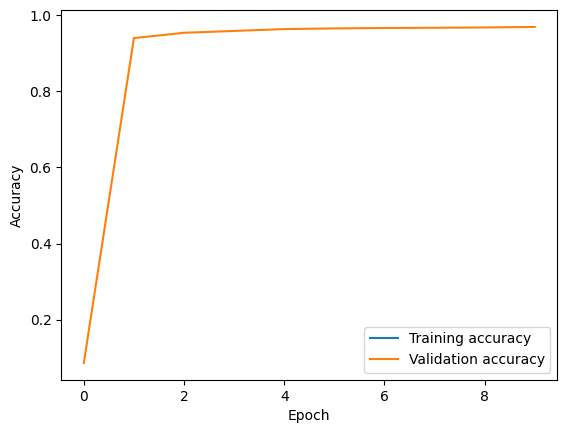

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc_values, label='Training accuracy')
plt.plot(val_acc_values, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Inference

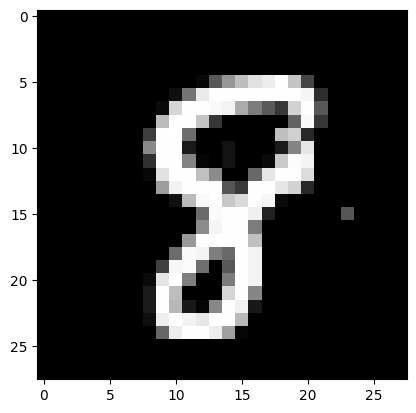

@main = primfn(A_1: handle, B_1: handle, compute_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [256], []),
             B: Buffer(B_2: Pointer(float32), float32, [30720], []),
             compute: Buffer(compute_2: Pointer(float32), float32, [120], [])}
  buffer_map = {A_1: A, B_1: B, compute_1: compute}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [1, 256], []), B_1: B_3: Buffer(B_2, float32, [256, 120], []), compute_1: compute_3: Buffer(compute_2, float32, [1, 120], [])} {
  for (j.outer: int32, 0, 30) {
    for (j.inner.init: int32, 0, 4) {
      compute[((j.outer*4) + j.inner.init)] = 0f32
    }
    for (k.outer: int32, 0, 64) {
      for (j.inner: int32, 0, 4) {
        let cse_var_2: int32 = (j.outer*4)
        let cse_var_1: int32 = (cse_var_2 + j.inner)
        compute[cse_var_1] = (compute[cse_var_1] + (A[(k.outer*4)]*B[(((k.outer*480) + cse_var_2)

In [ ]:
# visualize the data
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# pick a random image from the test set
idx = np.random.randint(0, test_set[0].shape[0])
img = test_set_x[idx:idx+1]
# plot the image
plt.imshow(img[0][0], cmap=cm.Greys_r)
plt.show()

# get predictions
test_X_val.copyfrom(img)
test_y_val.copyfrom(convert_to_one_hot(test_set_y[idx:idx+1]))
_, _, _, _, _, _, _, _, _, _, _, _, _, test_y_predicted = executor.run(
    feed_dict={
        X: test_X_val,
        y_: test_y_val,
        F1: F1_val,
        BN1_gamma: BN1_gamma_val,
        BN1_beta: BN1_beta_val,
        F2: F2_val,
        BN2_gamma: BN2_gamma_val,
        BN2_beta: BN2_beta_val,
        W1: W1_val,
        W2: W2_val,
        W3: W3_val,
        b1: b1_val,
        b2: b2_val,
        b3: b3_val},
    convert_to_numpy_ret_vals=True);
print("Predicted class = %d" % np.argmax(test_y_predicted))
print("Actual class = %d" % test_set_y[idx])